In [1]:
from skyfield.api import EarthSatellite, load
import numpy as np
import matplotlib.pyplot as plt

ts = load.timescale()
utc = ts.utc(2021,6,3,10,32,26)

In [25]:
utc2 = ts.utc(2021, 6, 3, 10, range(0,300))
utc2

<Time tt=[2459368.9174674074 ... 2459369.1251062965] len=300>

In [28]:
states = []
for sat in constellation_sats:

    states.append(sat.at(utc2).position.km)

In [5]:
constellation_sats = []
for idx, line in enumerate(tlelis):
    if idx % 3 == 0:
        if idx > 0:
            constellation_sats.append(EarthSatellite(tleline1, tleline2, satname, ts))            

        satname = line
    if (idx-1) % 3 == 0:
        tleline1 = line
    if (idx-2) % 3 == 0:
        tleline2 = line



In [11]:
distances = {}

for idx1, sat1 in enumerate(constellation_sats):
    distances[sat1.name] = []
    pos1 = sat1.at(utc).position.km
    for idx2,sat2 in enumerate(constellation_sats):    
        if idx2 == idx1:
            distances[sat1.name].append(0.0)
            continue
        pos2 = sat2.at(utc).position.km
        relvec = pos1 - pos2
        distances[sat1.name].append(np.linalg.norm(relvec))


array([ -138.12930706, -2230.77371719, -6454.69548614])

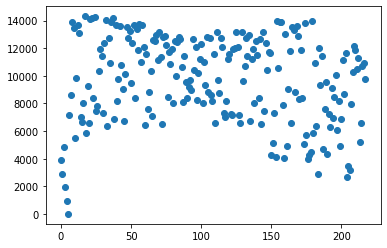

In [7]:
scale = 1 # 6372*2.0
plt.scatter(range(len(list(distances.values())[5])), [ dis/scale for dis in list(distances.values())[5]  ] )

In [8]:

onesat = constellation_sats[5]
pvcoord = onesat.at(utc)
print(pvcoord.ecliptic_latlon()[2].km - 6372)
print(np.linalg.norm(pvcoord.position.km) - 6372)

1182.3260417664524
1182.3260417664533


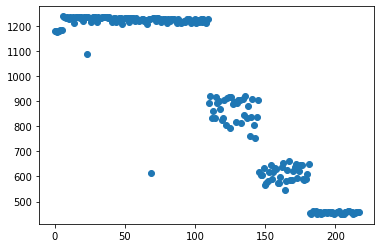

In [9]:
altitudes = np.array([np.linalg.norm(sat.at(utc).position.km) - 6372 for sat in constellation_sats])

plt.scatter(range(len(altitudes)), altitudes)

In [135]:
idxs = (altitudes > 500) * (altitudes < 700)

sum(idxs)
# altitudes[500>altitudes<700 ] 

37

In [ ]:
altitudes.

In [88]:
the_min_distance = 9e9


for satname, rel_dists in distances.items():
    for dist in rel_dists:
        if dist is None:
            continue
        if the_min_distance > dist and dist > 0:
            the_min_distance = dist

print(the_min_distance)
            

28.49185856265305


In [33]:
import plotly.graph_objs as go
import numpy as np
import plotly.io as pio


def trace_sphere(position, radius, name, color):
    
    phi = np.linspace(0, 2 * np.pi, num=20)
    theta = np.linspace(-np.pi / 2, np.pi / 2, num=20)
    phi, theta = np.meshgrid(phi, theta)

    x = 1e-3 * (position[0] +  np.cos(theta) * np.sin(phi) * radius)
    y = 1e-3 * (position[1] +  np.cos(theta) * np.cos(phi) * radius)
    z = 1e-3 * (position[2] +  np.sin(theta) * radius)

    return go.Mesh3d(
        x=x.flatten(),
        y=y.flatten(),
        z=z.flatten(),                   
        alphahull=0,                   
        opacity=1.0,
        color=color,
        name=name,
        lighting=dict(ambient=1))

def trace_trajectory(orbital_states, name, dash=True):
    orbit = orbital_states.getPVCoordinates().getPosition()
    return go.Scatter3d(
                x = 1e-3 * np.array([float(pos[0]()) for pos in orbit]),
                y = 1e-3 * np.array([float(pos[0]()) for pos in orbit]),
                z = 1e-3 * np.array([float(pos[0]()) for pos in orbit]),
                mode='lines', 
                line=dict(
                    width=3,
                    dash="dash" if dash else "solid",
                ),
                name=name)



def plot_orbits(orbital_states=[], orbit_labels=[], last_state_blop=True, first_state_blop=False, idx_no_init_blops=[], idx_no_last_blops=[], auto_labels=True, write_file=None):

    if not isinstance(orbital_states, list):
        orbital_states = [orbital_states]

    if orbit_labels == []:
        orbit_labels = [f"Orbit {it}" for it in range(1, len(orbital_states) + 1)]
    
    

    
    
    phi = np.linspace(0, 2*np.pi, num=20)
    theta = np.linspace(-np.pi/2, np.pi/2, num=20)
    phi, theta = np.meshgrid(phi, theta)

    x = 1e-3 * np.cos(theta) * np.sin(phi) * 6372e3
    y = 1e-3 * np.cos(theta) * np.cos(phi) * 6372e3
    z = 1e-3 * np.sin(theta) * 6372e3


    trace_earth = go.Mesh3d(
        x=x.flatten(),
        y=y.flatten(),
        z=z.flatten(),                   
        alphahull=0,                   
        opacity=1.0,
        color='#00AAFF',
        name='Earth',
        lighting=dict(ambient=1))
    
    data = [trace_earth]


    # _it = 1
    # orbit_labelnums = []
    # while len(orbit_labels) < len(orbital_states):
        
    #     orbit_labels.append(f"{_it}")
    #     _it += 1
    #     orbit_labelnums.append(_it)

    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']
    colormapping = lambda idx: colors[idx] if idx < len(colors) else colors[idx - len(colors)]

    
    
    for idx,  (orbit, label) in enumerate(zip(orbital_states, orbit_labels)):
        # if labels are e.g. [GEO, LEO, MEO] label becomes [GEO Orbit, LEO Orbit ..] else if labels are already in [GEO Orbit, Leo Orbit ] form, they stay the same
        label = f"{label} Orbit" if "orbit" not in label.lower() and  auto_labels else label 
        trace_orbit = go.Scatter3d(
                        x = 1e-3 * np.array(orbit[0,:]),
                        y = 1e-3 * np.array(orbit[1,:]),
                        z = 1e-3 * np.array(orbit[2,:]),
                        mode='lines',
                        line=dict(
                            width=3,
                            # cmin=0,
                            # cmax=len(orbit_labels) - 1,
                            color=colormapping(idx),
                        ),
                        name=label)
        
        data.append(trace_orbit)

        # last state spacecraft blops
        blop_positions = []
#         if first_state_blop and idx not in idx_no_init_blops:
#             blop_label =  "Chaser Initial State" if idx == 0 else "Target Initial State" 
#             initial_trace_spacecraft = go.Scatter3d(
#                                 x=1e-3 * np.array([ orbit[0][0] ]),
#                                 y=1e-3 * np.array([ orbit[0][1] ]),
#                                 z=1e-3 * np.array([ orbit[0][2] ]),
#                                 mode='markers',
#                                 marker=dict(
#                                 size=8,
                                
#                                 opacity=0.950,
#                                 # cmin=0,
#                                 # cmax=len(orbit_labels) - 1,
#                                 color=colormapping(idx),
#                                 # colorscale='Viridis',
                                
#                             ),
                                
#                                 name=blop_label,
#                                 showlegend=True,
#             )

#             data.append(initial_trace_spacecraft)
               
        if last_state_blop and idx not in idx_no_last_blops:
            final_trace_spacecraft = go.Scatter3d(
                                x=1e-3 * np.array([ orbit[-1][0] ]),
                                y=1e-3 * np.array([ orbit[-1][1] ]),
                                z=1e-3 * np.array([ orbit[-1][2] ]),
                                mode='markers',
                                marker=dict(
                                size=6,
                                
                                opacity=0.99,
                                # cmin=0,
                                # cmax=len(orbit_labels) - 1,
                                color=colormapping(idx),
                                # colorscale='Viridis',
                                
                            ),
                            
                                showlegend=False
            )

            data.append(final_trace_spacecraft)
    layout = go.Layout(
                        title = '3D trajectory plot in ECI frame',
                        width=1200,
                        height=650,
                        legend=dict(font=dict(size=20)),
                        scene=dict(
                        aspectmode='data', 
                        

                        
                        # bgcolor= "#151516",
                        bgcolor="black",
                        xaxis = dict(
                            title="",
                         backgroundcolor="rgb(0, 0, 0)",
                         gridcolor="black",
                         showticklabels=False,
                         showline=False,
                         showbackground=True,
                         zerolinecolor="black",),
                    yaxis = dict(
                        title="",
                        backgroundcolor="rgb(0, 0,0)",
                        gridcolor="black",
                        showticklabels=False,
                        showline=False,
                        showbackground=True,
                        zerolinecolor="black"),
                    zaxis = dict(
                        title="",
                        backgroundcolor="rgb(0, 0,0)",
                        gridcolor="black",
                        showticklabels=False,
                        showline=False,
                        showbackground=True,
                        zerolinecolor="black",),
                        )
                        
                        )

    fig = dict(data=data, layout=layout)

    pio.show(fig)


In [34]:


plot_orbits(orbital_states=states,) #orbit_labels=[sat["OBJECT_NAME"]for sat in constellation_sats], last_state_blop=True, first_state_blop=False, idx_no_init_blops=[], idx_no_last_blops=[], auto_labels=True, write_file=None)


IndexError: list index out of range

### TLE file


In [3]:
tlefull = """ONEWEB-0012             
1 44057U 19010A   21158.81745105 -.00000126  00000-0 -33697-3 0  9991
2 44057  87.9185 263.2851 0001946  98.5399 261.5956 13.21812000109800
ONEWEB-0010             
1 44058U 19010B   21158.81905107 -.00000104  00000-0 -28360-3 0  9999
2 44058  87.9187 263.2941 0002120 105.3304 254.8064 13.21810551109850
ONEWEB-0008             
1 44059U 19010C   21158.81585292 -.00000113  00000-0 -30546-3 0  9998
2 44059  87.9191 263.3075 0002175 105.4834 254.6540 13.21814733109958
ONEWEB-0007             
1 44060U 19010D   21158.82059678 -.00000079  00000-0 -22306-3 0  9991
2 44060  87.9185 263.2869 0002089  96.3622 263.7750 13.21810936109966
ONEWEB-0006             
1 44061U 19010E   21158.82214997 -.00000102  00000-0 -27904-3 0  9995
2 44061  87.9191 263.3048 0001978 100.4847 259.6510 13.21815911110021
ONEWEB-0011             
1 44062U 19010F   21158.82371054 -.00000072  00000-0 -20475-3 0  9996
2 44062  87.9195 263.3199 0001893  92.2835 267.8516 13.21810952110010
ONEWEB-0013             
1 45131U 20008A   21158.75225189 -.00000562  00000-0 -16703-2 0  9994
2 45131  87.9187  56.9281 0001378  66.1385 293.9886 13.09308196 65876
ONEWEB-0017             
1 45132U 20008B   21159.20556496  .00000595  00000-0  16679-2 0  9990
2 45132  87.8873  41.0572 0002529  78.7716 281.3695 13.10376262 68404
ONEWEB-0020             
1 45133U 20008C   21159.17438762 -.00000184  00000-0 -56348-3 0  9996
2 45133  87.8880  41.0514 0002628  60.9919 299.1471 13.10377317 68802
ONEWEB-0021             
1 45134U 20008D   21159.18996653  .00000536  00000-0  14983-2 0  9993
2 45134  87.8782  40.9923 0001588  79.4956 280.6350 13.10380630 69204
ONEWEB-0022             
1 45135U 20008E   21158.90947348  .00000103  00000-0  25836-3 0  9990
2 45135  87.8874  41.0999 0002360  76.3725 283.7665 13.10369397 67995
ONEWEB-0023             
1 45136U 20008F   21158.89700691  .00000642  00000-0  18040-2 0  9993
2 45136  87.8792  41.0952 0001129  56.4627 303.6608 13.10373665 67729
ONEWEB-0024             
1 45137U 20008G   21158.63833475 -.00000200  00000-0 -60800-3 0  9997
2 45137  87.8826  41.1616 0001454  75.9491 284.1798 13.10371947 67850
ONEWEB-0025             
1 45138U 20008H   21159.19153172  .00000605  00000-0  16961-2 0  9994
2 45138  87.8868  41.1155 0001616  74.1088 286.0218 13.10376066 69002
ONEWEB-0026             
1 45139U 20008J   21159.14547520 -.00107618  00000-0 -30846+0 0  9993
2 45139  87.8861  25.9478 0001748  80.4365 279.6960 13.11142500 71503
ONEWEB-0028             
1 45140U 20008K   21159.06217365 -.00038062  00000-0 -11158+0 0  9998
2 45140  87.4443  40.4466 0001508 157.2307 202.8886 13.09089364 68156
ONEWEB-0032             
1 45141U 20008L   21159.05439837  .00000549  00000-0  15371-2 0  9999
2 45141  87.8848  41.1432 0001688  83.4359 276.6960 13.10372339 68822
ONEWEB-0033             
1 45142U 20008M   21159.10426923  .00000111  00000-0  28265-3 0  9990
2 45142  87.8852  41.0736 0001713  80.3109 279.8212 13.10375411 68786
ONEWEB-0035             
1 45143U 20008N   21158.90793154  .00000673  00000-0  18925-2 0  9995
2 45143  87.8873  41.1275 0001874  70.9166 289.2164 13.10369824 67584
ONEWEB-0036             
1 45144U 20008P   21159.05130042  .00000595  00000-0  16675-2 0  9997
2 45144  87.8872  41.0606 0001598  69.9085 290.2214 13.10374595 68896
ONEWEB-0038             
1 45145U 20008Q   21159.14339938  .00000332  00000-0  90075-3 0  9999
2 45145  87.8929  25.8254 0001561  80.1484 279.9820 13.11419266 70602
ONEWEB-0039             
1 45146U 20008R   21159.18528679  .00000314  00000-0  86461-3 0  9990
2 45146  87.8877  41.0727 0001281 102.6146 257.5125 13.10377117 68620
ONEWEB-0040             
1 45147U 20008S   21159.17748833 -.00000501  00000-0 -14705-2 0  9997
2 45147  87.8878  41.1204 0001474  82.8395 277.2900 13.10374126 68337
ONEWEB-0041             
1 45148U 20008T   21158.92704667  .00000066  00000-0  83989-4 0  9993
2 45148  87.9365  25.0865 0019580  89.2065 271.1327 13.48324004 70741
ONEWEB-0043             
1 45149U 20008U   21158.64454549  .00000106  00000-0  26712-3 0  9999
2 45149  87.8880  41.1760 0001094  70.9527 289.1719 13.10379059 67791
ONEWEB-0044             
1 45150U 20008V   21158.90324852  .00000394  00000-0  10926-2 0  9991
2 45150  87.8871  41.1348 0001349  88.6585 271.4697 13.10371077 68127
ONEWEB-0045             
1 45151U 20008W   21158.92106892  .00000549  00000-0  15134-2 0  9994
2 45151  87.8884  25.9985 0001903  89.6367 270.4979 13.11415992 69864
ONEWEB-0047             
1 45152U 20008X   21159.04818213  .00000609  00000-0  17089-2 0  9994
2 45152  87.8874  41.0993 0001666  77.2607 282.8706 13.10370320 68653
ONEWEB-0048             
1 45153U 20008Y   21159.11985070  .00000692  00000-0  19451-2 0  9996
2 45153  87.8877  41.0765 0001489  73.3320 286.7971 13.10373943 68253
ONEWEB-0049             
1 45154U 20008Z   21158.89233854  .00000697  00000-0  19607-2 0  9995
2 45154  87.8869  41.1243 0001540  62.4903 297.6381 13.10375539 67675
ONEWEB-0051             
1 45155U 20008AA  21159.07147177  .00000451  00000-0  12380-2 0  9998
2 45155  87.8859  25.9623 0001809  82.6533 277.4801 13.11413189 71345
ONEWEB-0052             
1 45156U 20008AB  21158.73649732  .00000689  00000-0  19383-2 0  9998
2 45156  87.8867  41.1500 0001296  30.2924 329.8278 13.10375419 67563
ONEWEB-0053             
1 45157U 20008AC  21159.17593236 -.00000532  00000-0 -15594-2 0  9994
2 45157  87.8878  41.0792 0001357  84.1661 275.9621 13.10374367 68354
ONEWEB-0054             
1 45158U 20008AD  21158.90636248  .00000291  00000-0  79717-3 0  9994
2 45158  87.8871  41.1375 0001972  83.0379 277.0973 13.10376775 67675
ONEWEB-0056             
1 45159U 20008AE  21158.73496179  .00000668  00000-0  18779-2 0  9991
2 45159  87.8875  41.1646 0001609  72.8422 287.2881 13.10374351 67807
ONEWEB-0057             
1 45160U 20008AF  21158.81753703  .00000650  00000-0  18270-2 0  9998
2 45160  87.8876  41.1183 0001393  78.6201 281.5082 13.10372743 67987
ONEWEB-0058             
1 45161U 20008AG  21158.72871346  .00000463  00000-0  12898-2 0  9995
2 45161  87.8882  41.1560 0001633  90.3538 269.7776 13.10375067 68043
ONEWEB-0059             
1 45162U 20008AH  21159.18373634  .00000251  00000-0  68316-3 0  9996
2 45162  87.8879  41.0720 0001713  86.7174 273.4150 13.10379967 68749
ONEWEB-0062             
1 45163U 20008AJ  21158.90481518  .00000356  00000-0  98361-3 0  9996
2 45163  87.8872  41.1228 0001583  69.8714 290.2583 13.10375274 67837
ONEWEB-0065             
1 45164U 20008AK  21158.73026770  .00000509  00000-0  14231-2 0  9996
2 45164  87.8792  41.1055 0001656  78.7858 281.3456 13.10375639 67505
ONEWEB-0066             
1 45424U 20020A   21158.90144052 -.00000241  00000-0 -71567-3 0  9993
2 45424  87.8917  25.9541 0002357 105.3863 254.7525 13.11418226 62131
ONEWEB-0067             
1 45425U 20020B   21158.92760736  .00000507  00000-0  13935-2 0  9996
2 45425  87.8914  25.9573 0001673  89.8077 270.3243 13.11420913 62190
ONEWEB-0080             
1 45426U 20020C   21159.18264045 -.00000253  00000-0 -74897-3 0  9993
2 45426  87.8916  25.8888 0001984  74.6103 285.5244 13.11417330 62208
ONEWEB-0090             
1 45427U 20020D   21159.19790222 -.00000448  00000-0 -12995-2 0  9992
2 45427  87.8924  25.9079 0001819  82.4388 277.6947 13.11416215 62179
ONEWEB-0061             
1 45428U 20020E   21158.92543193  .00000568  00000-0  15675-2 0  9995
2 45428  87.8918  25.9268 0001656  92.4521 267.6797 13.11418923 62082
ONEWEB-0081             
1 45429U 20020F   21159.13686829  .00000067  00000-0  15194-3 0  9995
2 45429  87.8929  25.8521 0001820 107.2706 252.8621 13.11420547 62222
ONEWEB-0069             
1 45430U 20020G   21158.89491919 -.00000412  00000-0 -11970-2 0  9996
2 45430  87.8918  25.9605 0001721  82.6597 277.4727 13.11430673 62120
ONEWEB-0031             
1 45431U 20020H   21159.32651203 -.00000559  00000-0 -16123-2 0  9997
2 45431  87.8911  25.8701 0001563  76.1172 284.0130 13.11414645 62179
ONEWEB-0027             
1 45432U 20020J   21159.31909710 -.00000033  00000-0 -11904-3 0  9996
2 45432  87.9145  10.7108 0002176  87.4921 272.6460 13.17645982 64720
ONEWEB-0064             
1 45433U 20020K   21159.32428579  .00000219  00000-0  58343-3 0  9999
2 45433  87.8916  25.8801 0001643  94.6940 265.4376 13.11418294 62207
ONEWEB-0018             
1 45434U 20020L   21158.89707791 -.00000366  00000-0 -10688-2 0  9991
2 45434  87.8918  25.9447 0001605  78.9528 281.1780 13.11418787 62089
ONEWEB-0083             
1 45435U 20020M   21159.19135489 -.00000437  00000-0 -12679-2 0  9996
2 45435  87.8915  25.8913 0001698  83.1912 276.9409 13.11412760 62176
ONEWEB-0095             
1 45436U 20020N   21158.87091316 -.00000032  00000-0 -12506-3 0  9992
2 45436  87.8915  25.9562 0001993  80.2072 279.9280 13.11417032 62123
ONEWEB-0092             
1 45437U 20020P   21159.07583894  .00000612  00000-0  16896-2 0  9990
2 45437  87.8928  25.8591 0001312  73.0437 287.0835 13.11415957 62264
ONEWEB-0085             
1 45438U 20020Q   21158.87963158 -.00000384  00000-0 -11183-2 0  9995
2 45438  87.8916  25.9698 0001773  91.8845 268.2486 13.11416622 62121
ONEWEB-0096             
1 45439U 20020R   21158.88835806 -.00000529  00000-0 -15288-2 0  9996
2 45439  87.8917  25.9567 0001699  88.9669 271.1653 13.11421507 62112
ONEWEB-0037             
1 45440U 20020S   21158.87311001  .00000284  00000-0  76615-3 0  9991
2 45440  87.8913  25.9705 0001389  63.5666 296.5604 13.11415739 62146
ONEWEB-0042             
1 45441U 20020T   21158.85566357  .00000454  00000-0  12454-2 0  9995
2 45441  87.8916  25.9633 0001519  83.0153 277.1147 13.11417222 62116
ONEWEB-0098             
1 45442U 20020U   21158.87527153 -.00000201  00000-0 -60171-3 0  9991
2 45442  87.8913  25.9642 0001868  92.0798 268.0544 13.11417327 62099
ONEWEB-0055             
1 45443U 20020V   21159.31781440  .00000757  00000-0  20988-2 0  9998
2 45443  87.8924  25.8195 0001813  85.4675 274.6660 13.11414422 62134
ONEWEB-0093             
1 45444U 20020W   21159.52270997  .00000073  00000-0  17036-3 0  9994
2 45444  87.8916  25.8358 0001769  83.9212 276.2117 13.11422274 62226
ONEWEB-0029             
1 45445U 20020X   21158.85785107  .00000531  00000-0  14618-2 0  9995
2 45445  87.8920  25.9453 0002234  88.5274 271.6110 13.11421180 62100
ONEWEB-0068             
1 45446U 20020Y   21159.05619134 -.00000532  00000-0 -15367-2 0  9990
2 45446  87.8918  25.9270 0001887  93.9623 266.1720 13.11419575 62084
ONEWEB-0046             
1 45447U 20020Z   21158.89924076 -.00000525  00000-0 -15178-2 0  9998
2 45447  87.8918  25.9625 0001553  77.9237 282.2065 13.11418350 62061
ONEWEB-0063             
1 45448U 20020AA  21158.92976723  .00000558  00000-0  15382-2 0  9990
2 45448  87.8911  25.9631 0001474  68.0734 292.0551 13.11409872 62155
ONEWEB-0019             
1 45449U 20020AB  21159.13468924 -.00000035  00000-0 -13448-3 0  9998
2 45449  87.8920  25.8898 0001874  79.3215 280.8124 13.11421068 62032
ONEWEB-0094             
1 45450U 20020AC  21158.86503337  .00000010  00000-0 -82917-5 0  9998
2 45450  87.9125  10.7586 0001984  87.4370 272.6988 13.17664441 64616
ONEWEB-0087             
1 45451U 20020AD  21158.86220258  .00000309  00000-0  83609-3 0  9994
2 45451  87.8923  25.9687 0001763 105.5351 254.5972 13.11412835 62036
ONEWEB-0082             
1 45452U 20020AE  21159.32217391  .00000544  00000-0  14978-2 0  9994
2 45452  87.8914  25.8398 0001847 100.3201 259.8135 13.11415065 62199
ONEWEB-0050             
1 45453U 20020AF  21158.79351397  .00000338  00000-0  28271-4 0  9994
2 45453  87.5432 358.6293 0027941 129.4452 230.9258 14.94623226 66301
ONEWEB-0034             
1 45454U 20020AG  21158.88181476 -.00000406  00000-0 -11824-2 0  9996
2 45454  87.8914  25.9528 0001585  83.7820 276.3489 13.11416180 62046
ONEWEB-0060             
1 45455U 20020AH  21159.19574091 -.00000438  00000-0 -12722-2 0  9994
2 45455  87.8918  25.8864 0001721  80.5517 279.5805 13.11412817 62054
ONEWEB-0086             
1 45456U 20020AJ  21159.13905234  .00000210  00000-0  55740-3 0  9990
2 45456  87.8918  25.8967 0001789  93.1508 266.9825 13.11419255 62092
ONEWEB-0088             
1 45457U 20020AK  21158.88398518 -.00000536  00000-0 -15494-2 0  9997
2 45457  87.8911  25.9757 0001506  81.0495 279.0804 13.11412686 61993
ONEWEB-0102             
1 47258U 20100A   21159.48891211 -.00000338  00000-0 -97543-3 0  9998
2 47258  87.8903 355.4981 0002095  94.2032 265.9336 13.12438165 24075
ONEWEB-0109             
1 47259U 20100B   21159.04206304 -.00000486  00000-0 -13874-2 0  9992
2 47259  87.8874 355.4474 0002282  88.6951 271.4439 13.12443980 23846
ONEWEB-0110             
1 47260U 20100C   21158.83452750 -.00000109  00000-0 -33780-3 0  9999
2 47260  87.8924 355.5361 0002276  92.8523 267.2866 13.12442379 23988
ONEWEB-0111             
1 47261U 20100D   21159.09503371  .00000255  00000-0  67421-3 0  9994
2 47261  87.8926 355.5094 0001987  96.1664 263.9690 13.12442788 23853
ONEWEB-0114             
1 47262U 20100E   21158.59309651  .00000056  00000-0  11958-3 0  9997
2 47262  87.8851 355.5297 0002134  82.7578 277.3793 13.12447503 23747
ONEWEB-0117             
1 47263U 20100F   21158.81548175 -.00000060  00000-0 -20147-3 0  9996
2 47263  87.8877 355.5715 0002020  89.8212 270.3148 13.12444092 23789
ONEWEB-0118             
1 47264U 20100G   21159.45290708  .00000436  00000-0  11763-2 0  9992
2 47264  87.8909 355.4373 0002003  82.9952 277.1404 13.12437108 24063
ONEWEB-0119             
1 47265U 20100H   21159.48266429 -.00000194  00000-0 -57339-3 0  9992
2 47265  87.8901 355.5097 0002202  93.4160 266.7220 13.12434125 24043
ONEWEB-0120             
1 47266U 20100J   21159.05474512  .00000109  00000-0  26868-3 0  9997
2 47266  87.8975 355.4193 0002087  81.7671 278.3695 13.12434536 24017
ONEWEB-0121             
1 47267U 20100K   21158.81121868 -.00000560  00000-0 -15917-2 0  9999
2 47267  87.8983 355.5141 0001919  96.6937 263.4410 13.12441051 23899
ONEWEB-0122             
1 47268U 20100L   21159.10984060 -.00000428  00000-0 -12262-2 0  9997
2 47268  87.8893 355.4897 0001962  84.1794 275.9558 13.12444872 23848
ONEWEB-0123             
1 47269U 20100M   21158.79852624 -.00000337  00000-0 -97178-3 0  9991
2 47269  87.8918 355.5941 0002028  86.8595 273.2766 13.12422800 23940
ONEWEB-0124             
1 47270U 20100N   21159.46982502 -.00000322  00000-0 -93011-3 0  9993
2 47270  87.8888 355.4372 0001900  89.5714 270.5632 13.12449148 23919
ONEWEB-0125             
1 47271U 20100P   21158.83877532  .00000476  00000-0  12879-2 0  9990
2 47271  87.8961 355.5380 0001773  88.6695 271.4637 13.12444304 23899
ONEWEB-0126             
1 47272U 20100Q   21158.78794565 -.00000075  00000-0 -24333-3 0  9995
2 47272  87.8916 355.6429 0002149  99.5304 260.6067 13.12444043 23955
ONEWEB-0127             
1 47273U 20100R   21159.05691040  .00000387  00000-0  10400-2 0  9994
2 47273  87.8894 355.5180 0002462  84.2817 275.8592 13.12443387 24011
ONEWEB-0128             
1 47274U 20100S   21158.84724023 -.00000350  00000-0 -10089-2 0  9994
2 47274  87.8917 355.5436 0002106  93.4612 266.6758 13.12442073 24004
ONEWEB-0129             
1 47275U 20100T   21158.60160434  .00000322  00000-0  85945-3 0  9990
2 47275  87.8927 355.5133 0003192  72.5000 287.6477 13.12366231 23905
ONEWEB-0130             
1 47276U 20100U   21159.46557727  .00007784  00000-0  21600-1 0  9996
2 47276  87.8949 355.3910 0002019  98.8028 261.3329 13.12390454 23986
ONEWEB-0131             
1 47277U 20100V   21158.77525654  .00000461  00000-0  12452-2 0  9995
2 47277  87.8946 355.4758 0002088  90.6549 269.4818 13.12442137 23932
ONEWEB-0132             
1 47278U 20100W   21158.80911522 -.00000731  00000-0 -20686-2 0  9993
2 47278  87.8910 355.6352 0001856  80.4607 279.6731 13.12443852 23831
ONEWEB-0133             
1 47279U 20100X   21158.59525415  .00000074  00000-0  17011-3 0  9999
2 47279  87.8934 355.5363 0002064  87.0887 273.0477 13.12439962 23960
ONEWEB-0134             
1 47280U 20100Y   21159.47831195 -.00000694  00000-0 -19653-2 0  9997
2 47280  87.8900 355.4349 0001625  95.5496 264.5817 13.12441093 24052
ONEWEB-0135             
1 47281U 20100Z   21158.91290400  .00000721  00000-0  19692-2 0  9996
2 47281  87.8906 355.5284 0002244  89.2771 270.8615 13.12448849 24009
ONEWEB-0136             
1 47282U 20100AA  21159.46774850  .00000195  00000-0  50643-3 0  9991
2 47282  87.8929 355.3492 0002281  97.3797 262.7590 13.12445138 24003
ONEWEB-0137             
1 47283U 20100AB  21159.04841201 -.00001127  00000-0 -31687-2 0  9995
2 47283  87.8888 355.5954 0002025  77.2668 282.8687 13.12447048 23857
ONEWEB-0138             
1 47284U 20100AC  21159.09926763  .00000313  00000-0  83593-3 0  9996
2 47284  87.8893 355.5673 0002124  89.3148 270.8224 13.12442785 23946
ONEWEB-0139             
1 47285U 20100AD  21158.91714524  .00000609  00000-0  16568-2 0  9992
2 47285  87.8946 355.5644 0001988  95.1406 264.9950 13.12445744 23996
ONEWEB-0140             
1 47286U 20100AE  21159.47200778  .00000130  00000-0  32563-3 0  9999
2 47286  87.8923 355.4481 0002335  94.4624 265.6771 13.12436180 24029
ONEWEB-0141             
1 47287U 20100AF  21158.77735638  .00000313  00000-0  83374-3 0  9999
2 47287  87.8898 355.6170 0002129  87.8406 272.2966 13.12447743 23928
ONEWEB-0142             
1 47288U 20100AG  21159.48676755 -.00000259  00000-0 -75624-3 0  9993
2 47288  87.8923 355.5202 0001839  74.3659 285.7673 13.12444796 24011
ONEWEB-0143             
1 47289U 20100AH  21159.06112004  .00000285  00000-0  75735-3 0  9990
2 47289  87.8946 355.4502 0001942  88.3783 271.7568 13.12448907 23933
ONEWEB-0144             
1 47290U 20100AJ  21158.80700998 -.00000336  00000-0 -96947-3 0  9995
2 47290  87.8873 355.4784 0001869  98.1357 261.9983 13.12441955 23826
ONEWEB-0145             
1 47291U 20100AK  21158.84936481  .00000389  00000-0  10461-2 0  9990
2 47291  87.8921 355.5528 0002136  90.3135 269.8239 13.12442541 24020
ONEWEB-0146             
1 47292U 20100AL  21158.84514246  .00000580  00000-0  15763-2 0  9995
2 47292  87.8908 355.6016 0002102  92.0012 268.1357 13.12441685 23935
ONEWEB-0147             
1 47293U 20100AM  21159.04631125 -.00000212  00000-0 -62574-3 0  9992
2 47293  87.8926 355.5310 0003018  94.7551 265.3922 13.12449876 23854
ONEWEB-0115             
1 48042U 21025A   21159.58334491  .00000016  00000-0  00000+0 0  9999
2 48042  87.6974 325.8622 0007821  24.0491   4.0604 13.99832893 12559
ONEWEB-0152             
1 48043U 21025B   21159.58334491 -.00049137  00000-0 -35195-1 0  9994
2 48043  87.6799 325.8891 0010057  10.6572 147.5961 13.97494549 12536
ONEWEB-0153             
1 48044U 21025C   21159.58334491 -.01376678  00000-0 -99389+0 0  9992
2 48044  87.6974 325.8687 0011422  30.8727 247.8875 14.00518121 12523
ONEWEB-0154             
1 48045U 21025D   21159.58334491 -.01086482  00000-0 -82022+0 0  9990
2 48045  87.6017 325.8510 0007705  26.0100  28.1052 13.97729101 12487
ONEWEB-0116             
1 48046U 21025E   21159.25002315 -.01385947  00000-0 -90814+0 0  9998
2 48046  87.7426 325.9209 0008601  19.9950 161.5944 14.05984937 12526
ONEWEB-0150             
1 48047U 21025F   21159.58334491 -.00049214  00000-0 -35451-1 0  9999
2 48047  87.6782 325.8878 0007330 353.0407 119.2662 13.97186000 12521
ONEWEB-0107             
1 48048U 21025G   21159.25002315  .00018674  00000-0  13143-1 0  9999
2 48048  87.6209 325.9356 0011737  31.9727 119.4771 13.97897817 12462
ONEWEB-0101             
1 48049U 21025H   21159.58334491 -.00053192  00000-0 -38294-1 0  9999
2 48049  87.6899 325.8385 0008607  13.2462 314.5282 13.97242801 12484
ONEWEB-0113             
1 48050U 21025J   21158.92370678 -.00391246  00000-0 -25894+0 0  9990
2 48050  87.6863 326.0040 0008618   4.9189 355.2074 14.04013387 12444
ONEWEB-0112             
1 48051U 21025K   21159.25002315 -.01367109  00000-0 -89626+0 0  9993
2 48051  87.7335 325.8999 0007952  32.5477 106.8316 14.05905725 12511
ONEWEB-0156             
1 48052U 21025L   21158.91667824 -.01344547  00000-0 -86330+0 0  9998
2 48052  87.7131 326.0089 0010904  18.9126  14.5793 14.06983268  1857
ONEWEB-0161             
1 48053U 21025M   21159.25002315  .00021900  00000-0  15523-1 0  9995
2 48053  87.6235 325.9188 0009065  34.1106  49.2121 13.97496810 12431
ONEWEB-0158             
1 48054U 21025N   21159.25002315 -.01209150  00000-0 -72333+0 0  9994
2 48054  87.7094 325.9198 0009862  31.9901  93.4708 14.10503061 12503
ONEWEB-0157             
1 48055U 21025P   21159.58334491 -.00049360  00000-0 -35677-1 0  9990
2 48055  87.6476 325.9579 0008234  12.1691  93.3812 13.96992977 12549
ONEWEB-0162             
1 48056U 21025Q   21159.58334491 -.00051578  00000-0 -37117-1 0  9996
2 48056  87.6053 325.8582 0008537  18.5888 211.2938 13.97254379 12478
ONEWEB-0155             
1 48057U 21025R   21159.25002315 -.01202961  00000-0 -58354+0 0  9997
2 48057  87.7535 325.8657 0010980  20.9526  80.2105 14.21761589 12552
ONEWEB-0149             
1 48058U 21025S   21159.25002315  .00016290  00000-0  11599-1 0  9995
2 48058  87.6100 325.9500 0010154  38.1652 193.3278 13.97266363 12438
ONEWEB-0148             
1 48059U 21025T   21159.58334491  .00000017  00000-0  00000+0 0  9998
2 48059  87.7128 325.8337 0009851  13.7955  22.2863 14.01432054 12544
ONEWEB-0160             
1 48060U 21025U   21159.16667824 -.00031058  00000-0 -21995-1 0  9992
2 48060  87.6287 325.9676 0006673  35.2983  30.2778 13.98022762 12435
ONEWEB-0163             
1 48061U 21025V   21159.25002315 -.01340583  00000-0 -77451+0 0  9994
2 48061  87.7713 325.9138 0011019  12.2962 308.3865 14.12767981 12551
ONEWEB-0159             
1 48062U 21025W   21159.58334491  .00000016  00000-0  00000+0 0  9991
2 48062  87.7044 325.8768 0006724   7.5004 118.1609 14.00732980 12559
ONEWEB-0164             
1 48063U 21025X   21159.58334491 -.00049525  00000-0 -35202-1 0  9996
2 48063  87.6379 325.8644 0010851  11.7016  85.3826 13.97924803 12524
ONEWEB-0167             
1 48064U 21025Y   21159.25002315  .00020649  00000-0  13554-1 0  9998
2 48064  87.6705 325.9353 0009166  34.9182 294.2772 14.01798561 12453
ONEWEB-0166             
1 48065U 21025Z   21159.25002315 -.01204354  00000-0 -67529+0 0  9998
2 48065  87.7399 325.9292 0010818  13.3689  33.8834 14.14010496 12549
ONEWEB-0151             
1 48066U 21025AA  21159.58334491  .00000016  00000-0  00000+0 0  9995
2 48066  87.7142 325.8835 0006865   7.7638 179.8797 13.99995616 12554
ONEWEB-0170             
1 48067U 21025AB  21158.75058012 -.00132728  00000-0 -74921-1 0  9999
2 48067  87.6329 326.0407 0012070  23.9214 336.2529 14.11257368 12387
ONEWEB-0168             
1 48068U 21025AC  21159.25002315  .00021822  00000-0  15544-1 0  9997
2 48068  87.6285 325.9378 0008011  33.0190 331.6822 13.97226942 12415
ONEWEB-0173             
1 48069U 21025AD  21159.58334491 -.00052734  00000-0 -24804-1 0  9994
2 48069  87.7395 325.8031 0006356  26.4514 154.4251 14.20444694 12588
ONEWEB-0171             
1 48070U 21025AE  21159.58334491  .00000017  00000-0  00000+0 0  9991
2 48070  87.7065 325.8524 0011034  23.9135 101.6046 14.02201796 12570
ONEWEB-0172             
1 48071U 21025AF  21159.58334491 -.00058674  00000-0 -17557-1 0  9993
2 48071  87.7481 325.5035 0006420  13.7170 248.6254 14.43411821 12611
ONEWEB-0174             
1 48072U 21025AG  21159.25002315  .00022557  00000-0  10505-1 0  9990
2 48072  87.7714 325.8872 0011082 355.0158  42.9564 14.20326996 12589
ONEWEB-0175             
1 48073U 21025AH  21159.25002315  .00022527  00000-0  15961-1 0  9999
2 48073  87.5953 325.9301 0009472  35.3636  25.0886 13.97514886 12433
ONEWEB-0177             
1 48074U 21025AJ  21158.91667824 -.01358047  00000-0 -74680+0 0  9997
2 48074  87.7657 325.9798 0011142 358.5639 143.2409 14.15493825  1855
ONEWEB-0178             
1 48075U 21025AK  21159.25002315 -.01380782  00000-0 -65047+0 0  9992
2 48075  87.8143 325.8890 0011178 356.1122 355.5730 14.23807834 12595
ONEWEB-0108             
1 48076U 21025AL  21159.25002315 -.01356771  00000-0 -87429+0 0  9992
2 48076  87.7504 325.9379 0010306   5.5060 216.7997 14.06821514 12558
ONEWEB-0169             
1 48077U 21025AM  21159.25002315  .00021776  00000-0  15386-1 0  9999
2 48077  87.6633 325.9709 0010962  17.4755  64.5141 13.97667953 12429
ONEWEB-0176             
1 48210U 21031A   21159.50001157 -.00953879  00000-0 -14306+0 0  9995
2 48210  87.5376 298.3146 0009860 115.4993 163.8466 14.77759340  7919
ONEWEB-0184             
1 48211U 21031B   21159.16667824 -.01146667  00000-0 -19663+0 0  9998
2 48211  87.5001 298.4440 0011763 103.2810 326.3006 14.72070675  6558
ONEWEB-0179             
1 48212U 21031C   21159.50001157 -.00921792  00000-0 -12322+0 0  9992
2 48212  87.5507 298.3143 0012001 122.5348 248.6850 14.82450450  6631
ONEWEB-0180             
1 48213U 21031D   21159.16667824 -.01137717  00000-0 -23334+0 0  9996
2 48213  87.4764 298.5217 0010034 112.2609 200.2639 14.64184627  6549
ONEWEB-0218             
1 48214U 21031E   21159.50001157 -.01212509  00000-0 -14890+0 0  9996
2 48214  87.5739 298.2750 0013768  92.5291 121.3937 14.86244747  6645
ONEWEB-0209             
1 48215U 21031F   21159.50001157 -.01217201  00000-0 -16860+0 0  9990
2 48215  87.5512 298.3134 0011460 113.1639  54.7237 14.81333308  6633
ONEWEB-0198             
1 48216U 21031G   21159.50001157 -.00889405  00000-0 -11796+0 0  9994
2 48216  87.5176 298.3018 0008499 106.5591  70.9639 14.82714480  6600
ONEWEB-0189             
1 48217U 21031H   21159.16667824 -.01145900  00000-0 -20217+0 0  9990
2 48217  87.5010 298.4887 0012750 110.1332 215.8142 14.70820703  6569
ONEWEB-0196             
1 48218U 21031J   21159.16667824 -.01143096  00000-0 -22998+0 0  9993
2 48218  87.4611 298.4649 0009884 114.6253 292.6086 14.65060442  6545
ONEWEB-0183             
1 48219U 21031K   21159.16667824 -.01134698  00000-0 -17272+0 0  9991
2 48219  87.5267 298.4207 0009065 111.6130  45.7544 14.77174377  6571
ONEWEB-0185             
1 48220U 21031L   21159.16667824 -.01148279  00000-0 -19262+0 0  9994
2 48220  87.5131 298.4730 0011688  99.9124  60.2367 14.73027484  6565
ONEWEB-0187             
1 48221U 21031M   21159.16667824 -.01148846  00000-0 -21158+0 0  9992
2 48221  87.4797 298.4476 0012237 115.4790   4.6631 14.68959654  6556
ONEWEB-0192             
1 48222U 21031N   21159.16667824 -.01133698  00000-0 -23541+0 0  9990
2 48222  87.4392 298.4614 0010102 107.6482 146.4693 14.63618004  6539
ONEWEB-0219             
1 48223U 21031P   21159.50001157 -.00930027  00000-0 -11303+0 0  9993
2 48223  87.5768 298.2746 0013294  93.0881 108.9313 14.86369342  6645
ONEWEB-0202             
1 48224U 21031Q   21159.16667824 -.01218065  00000-0 -16223+0 0  9993
2 48224  87.5604 298.4041 0012800 109.0268 199.3060 14.82944388  6585
ONEWEB-0204             
1 48225U 21031R   21159.16667824 -.01145350  00000-0 -17983+0 0  9994
2 48225  87.5171 298.4297 0008916 104.9417 323.4773 14.75887479  6569
ONEWEB-0205             
1 48226U 21031S   21158.91667824 -.01148171  00000-0 -20057+0 0  9997
2 48226  87.4957 298.5254 0013387 111.7756 243.5278 14.71250569  1797
ONEWEB-0206             
1 48227U 21031T   21159.16667824 -.01131604  00000-0 -22352+0 0  9999
2 48227  87.4683 298.4552 0010366 113.1505   6.2571 14.65839663  6534
ONEWEB-0182             
1 48228U 21031U   21159.50001157 -.01013444  00000-0 -10699+0 0  9991
2 48228  87.5627 298.2393 0009622 116.1470 244.3689 14.92318418  6638
ONEWEB-0186             
1 48229U 21031V   21158.91667824 -.00913642  00000-0 -10843+0 0  9994
2 48229  87.5664 298.4306 0010153  97.1889 359.4255 14.87325227  1776
ONEWEB-0181             
1 48230U 21031W   21159.16667824 -.01122426  00000-0 -20795+0 0  9994
2 48230  87.5063 298.4670 0012202 116.0421 302.6060 14.68622207  6546
ONEWEB-0188             
1 48231U 21031X   21159.16667824 -.01136991  00000-0 -24446+0 0  9994
2 48231  87.4238 298.4331 0009985 102.6660 352.2708 14.62063205  6523
ONEWEB-0220             
1 48232U 21031Y   21159.50001157 -.01204753  00000-0 -15499+0 0  9994
2 48232  87.5634 298.2839 0013660  98.0390 301.1733 14.84325096  6635
ONEWEB-0165             
1 48233U 21031Z   21159.50001157 -.00932547  00000-0 -12568+0 0  9997
2 48233  87.5646 298.3080 0012278 109.4002 139.9144 14.82141789  6624
ONEWEB-0199             
1 48234U 21031AA  21159.16667824 -.01131830  00000-0 -18337+0 0  9996
2 48234  87.5073 298.4174 0009192  99.0062 213.1501 14.74505672  6555
ONEWEB-0203             
1 48235U 21031AB  21159.50001157 -.01242986  00000-0 -23183+0 0  9996
2 48235  87.4830 298.3517 0013158 110.0623  36.5660 14.68126310  6598
ONEWEB-0197             
1 48236U 21031AC  21159.16667824 -.01145755  00000-0 -22631+0 0  9991
2 48236  87.4553 298.4530 0010271 120.1398  46.2885 14.65883388  6534
ONEWEB-0194             
1 48237U 21031AD  21158.91667824 -.01151658  00000-0 -15364+0 0  9998
2 48237  87.5558 298.4847 0010209 115.6084 112.4681 14.82732681  6532
ONEWEB-0193             
1 48238U 21031AE  21159.16667824 -.01132778  00000-0 -18549+0 0  9997
2 48238  87.5124 298.4279 0011122  98.6484 110.2789 14.74029461  6553
ONEWEB-0191             
1 48239U 21031AF  21159.16667824 -.01161229  00000-0 -23112+0 0  9993
2 48239  87.4531 298.4502 0010772 116.6194  78.0078 14.65584917  6535
ONEWEB-0195             
1 48240U 21031AG  21159.16667824 -.01147913  00000-0 -24302+0 0  9991
2 48240  87.4323 298.4585 0009779 101.4312  78.0513 14.62794891  6520
ONEWEB-0201             
1 48241U 21031AH  21159.50001157 -.00726399  00000-0 -88504-1 0  9997
2 48241  87.5787 298.2995 0013582  96.2566  54.9289 14.86034861  6633
ONEWEB-0207             
1 48242U 21031AJ  21159.16667824 -.01281369  00000-0 -17771+0 0  9999
2 48242  87.5490 298.4126 0012008 113.1846  22.7066 14.81446124  6567
ONEWEB-0208             
1 48243U 21031AK  21159.50001157 -.01215797  00000-0 -17269+0 0  9993
2 48243  87.5473 298.2901 0009542 103.2248 199.5175 14.80304371  6608
ONEWEB-0200             
1 48244U 21031AL  21159.16667824 -.01153053  00000-0 -20302+0 0  9993
2 48244  87.4950 298.4452 0013163 106.9857 249.8643 14.70923949  6540
ONEWEB-0217             
1 48245U 21031AM  21159.16667824 -.01147841  00000-0 -22658+0 0  9998
2 48245  87.4541 298.4759 0009998 118.2714  17.4893 14.65920304  6537
ONEWEB-0211             
1 48767U 21045A   21158.91667824 -.00051411  00000-0 -12581-2 0  9997
2 48767  87.4001 273.0176 0004455 229.7545  93.0489 15.41029682  1813
ONEWEB-0223             
1 48768U 21045B   21158.91667824 -.00049862  00000-0 -11581-2 0  9994
2 48768  87.3969 273.0079 0009318 205.1598 172.9791 15.42558219  1791
ONEWEB-0230             
1 48769U 21045C   21158.91667824 -.00061730  00000-0 -16709-2 0  9990
2 48769  87.3963 273.0301 0005226 212.0109   0.4134 15.37976905  1799
ONEWEB-0237             
1 48770U 21045D   21159.50001157 -.00039690  00000-0 -10157-2 0  9990
2 48770  87.3956 272.8127 0008147 220.4973  41.3727 15.39604835  2945
ONEWEB-0235             
1 48771U 21045E   21159.50001157 -.00040479  00000-0 -10810-2 0  9994
2 48771  87.3985 272.8235 0004292 229.7727 343.3166 15.38325146  2928
ONEWEB-0242             
1 48772U 21045F   21158.91667824 -.00052616  00000-0 -12582-2 0  9992
2 48772  87.3974 273.0098 0007728 229.6246 119.0291 15.41707549  1807
ONEWEB-0241             
1 48773U 21045G   21159.50001157 -.00038841  00000-0 -96719-3 0  9999
2 48773  87.3998 272.8139 0005336 198.8764  95.4160 15.40456412  2949
ONEWEB-0243             
1 48774U 21045H   21158.91667824 -.00056026  00000-0 -14432-2 0  9999
2 48774  87.4003 273.0283 0007951 227.0485  38.8807 15.39459129  1800
ONEWEB-0222             
1 48775U 21045J   21158.91667824 -.00050496  00000-0 -11988-2 0  9998
2 48775  87.3991 273.0139 0008263 225.6517 129.1502 15.41913454  1808
ONEWEB-0244             
1 48776U 21045K   21158.91667824 -.00054040  00000-0 -13413-2 0  9993
2 48776  87.4014 273.0242 0004599 205.0801 103.0594 15.40608399  1807
ONEWEB-0247             
1 48777U 21045L   21159.16667824  .00072239  00000-0  17687-2 0  9997
2 48777  87.3968 272.9281 0004952 202.6841  48.0835 15.40480646  2884
ONEWEB-0245             
1 48778U 21045M   21159.50001157 -.00043131  00000-0 -11000-2 0  9991
2 48778  87.3986 272.8159 0008136 216.9634  49.4894 15.39719788  2941
ONEWEB-0229             
1 48779U 21045N   21159.50001157 -.00044938  00000-0 -11076-2 0  9991
2 48779  87.3993 272.8101 0003840 217.1842  90.3577 15.40794094  2946
ONEWEB-0228             
1 48780U 21045P   21159.50001157 -.00039322  00000-0 -99182-3 0  9999
2 48780  87.3990 272.8123 0007200 205.5149  73.4501 15.40053290  2938
ONEWEB-0232             
1 48781U 21045Q   21158.91667824 -.00055036  00000-0 -14310-2 0  9992
2 48781  87.3987 273.0280 0007481 237.5139  18.4305 15.39173767  1915
ONEWEB-0231             
1 48782U 21045R   21158.91667824 -.00048864  00000-0 -11901-2 0  9997
2 48782  87.3982 273.0165 0004890 234.0543  93.3367 15.41162692  1913
ONEWEB-0234             
1 48783U 21045S   21158.91667824 -.00054539  00000-0 -13719-2 0  9993
2 48783  87.3980 273.0235 0006540 204.7733  87.6045 15.40190966  1844
ONEWEB-0238             
1 48784U 21045T   21159.50001157 -.00036069  00000-0 -86210-3 0  9996
2 48784  87.4000 272.8088 0007470 227.4115 113.5293 15.41672770  2946
ONEWEB-0240             
1 48785U 21045U   21159.50001157 -.00038202  00000-0 -94044-3 0  9992
2 48785  87.3981 272.8088 0004205 211.5805  96.2754 15.40808438  2936
ONEWEB-0246             
1 48786U 21045V   21158.91667824 -.00059742  00000-0 -15858-2 0  9993
2 48786  87.3992 273.0307 0004857 241.3925 352.6012 15.38574568  1805
ONEWEB-0210             
1 48787U 21045W   21158.91667824 -.00054166  00000-0 -13739-2 0  9995
2 48787  87.3982 273.0239 0007458 209.1433  73.8831 15.39928701  1810
ONEWEB-0214             
1 48788U 21045X   21158.91667824 -.00061143  00000-0 -16428-2 0  9997
2 48788  87.3973 273.0313 0004492 220.4229   0.4089 15.38207996  1847
ONEWEB-0221             
1 48789U 21045Y   21159.50001157 -.00033704  00000-0 -77888-3 0  9995
2 48789  87.3997 272.8012 0009551 200.7620 178.1640 15.42659669  2956
ONEWEB-0213             
1 48790U 21045Z   21158.91667824 -.00050198  00000-0 -11753-2 0  9994
2 48790  87.3981 273.0105 0009271 211.5464 157.8995 15.42319643  1852
ONEWEB-0212             
1 48791U 21045AA  21158.91667824 -.00049957  00000-0 -11658-2 0  9990
2 48791  87.4018 273.0132 0009292 208.7055 164.3942 15.42417587  1796
ONEWEB-0227             
1 48792U 21045AB  21158.91667824 -.00054228  00000-0 -13592-2 0  9997
2 48792  87.3985 273.0204 0006159 202.3255  94.0298 15.40301512  1847
ONEWEB-0226             
1 48793U 21045AC  21158.91667824 -.00053495  00000-0 -13947-2 0  9997
2 48793  87.3965 273.0237 0007075 239.2759  13.0595 15.39089025  1917
ONEWEB-0224             
1 48794U 21045AD  21158.91667824 -.00062063  00000-0 -16869-2 0  9995
2 48794  87.3994 273.0359 0005658 208.7091 359.1310 15.37847512  1796
ONEWEB-0233             
1 48795U 21045AE  21158.91667824 -.00061432  00000-0 -16578-2 0  9992
2 48795  87.4000 273.0369 0004864 215.9277   0.1697 15.38071935  1791
ONEWEB-0190             
1 48796U 21045AF  21158.91667824 -.00058191  00000-0 -15252-2 0  9999
2 48796  87.3983 273.0310 0006579 242.1966   5.2217 15.38946598  1812
ONEWEB-0236             
1 48797U 21045AG  21158.91667824 -.00056224  00000-0 -14982-2 0  9994
2 48797  87.3958 273.0298 0004437 237.0036 352.0999 15.38445325  1892
ONEWEB-0248             
1 48798U 21045AH  21158.91667824 -.00050719  00000-0 -12198-2 0  9995
2 48798  87.3991 273.0138 0006909 231.5915 109.8247 15.41535603  1789
ONEWEB-0225             
1 48799U 21045AJ  21158.91667824 -.00049233  00000-0 -12086-2 0  9991
2 48799  87.3971 273.0176 0004080 225.4017  93.4430 15.40928761  1897
ONEWEB-0215             
1 48800U 21045AK  21158.91667824 -.00058685  00000-0 -15442-2 0  9994
2 48800  87.3970 273.0270 0006194 244.5607 358.7543 15.38830784  1817
ONEWEB-0216             
1 48801U 21045AL  21158.91667824 -.00059380  00000-0 -15707-2 0  9992
2 48801  87.3969 273.0290 0005258 244.5000 353.2942 15.38678112  1846
ONEWEB-0239             
1 48802U 21045AM  21159.50001157 -.00039834  00000-0 -10275-2 0  9997
2 48802  87.3969 272.8157 0008205 228.0621  24.4831 15.39361729  2936
"""

In [4]:
tlelis = tlefull.split("\n")